# Выбор локации для скважины

Компании «ГлавРосГосНефть» нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## Загрузка и подготовка данных

In [1]:
# импортируем задействованные библиотеки
import pandas as pd
import numpy as np
from scipy import stats as st

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
# Зададим параметры отображения значений и графиков
%matplotlib inline
pd.options.display.float_format = '{:,.3f}'.format
plt.style.use('seaborn')

In [3]:
# переменные для проекта
WELL_POINTS = 500           # количество скважин в регионе
BOOTSTRAP_SAMPLES = 1000    # количество выборок для бутстрепа
TOTAL_BUDGET = 10e9         # общий бюджет на разаботку скважин в регионе
WELLS_PER_REGION = 200      # плановое число скважин на регион
BARREL_PROFIT = 450e3       # доход с продажи тысячи баррелей
RISK_TRESHOLD = 0.025       # граница вероятности убытков
CONF_INTERVAL = 0.95        # доверительный интервал
SEED = 666                  # псевдослучайное состояние генератора

In [4]:
# загружаем данные, пропуская первый столбец id
try:
    well_1 = pd.read_csv('../01-data/geo_data_0.csv', usecols=[1, 2, 3, 4])
    well_2 = pd.read_csv('../01-data/geo_data_1.csv', usecols=[1, 2, 3, 4])
    well_3 = pd.read_csv('../01-data/geo_data_2.csv', usecols=[1, 2, 3, 4])
except FileNotFoundError:
    well_1 = pd.read_csv('/datasets/geo_data_0.csv', usecols=[1, 2, 3, 4])
    well_2 = pd.read_csv('/datasets/geo_data_1.csv', usecols=[1, 2, 3, 4])
    well_3 = pd.read_csv('/datasets/geo_data_2.csv', usecols=[1, 2, 3, 4])


<div style="border:solid #8B008B 1px; padding: 20px">
В датасетах представлены данные по скважинам в трех регионах. Условно назовем из регион 1, регион 2 и регион 3. 

Объекты представляют данные измерений по отдельным скважинам. Известно, что целевая переменная - product - показывает объем запасов скважины, а признаки f0, f1, f2 - это некие параметры скважины.

Изучим имеющуюся информацию по каждому региону.

In [5]:
def df_describe(data):
    # функция выводит ключевые статистики и соотношения датасета
    print('Описание переменных')
    print(data.describe())
    print('*' * 43)
    print(data.info())
    print('*' * 43)
    print('Выборка:\n', data.sample(3))
    print('*' * 43)
    print(f'Явные дубликаты: {data.duplicated().sum()}')
    print('*' * 43)
    print('Корреляция Пирсона:')
    pearson = data.corr()
    corr = sns.heatmap(pearson, cmap='Blues_r', annot=True)
    plt.show()
    print('Парные графики признаков:')
    sns.pairplot(data, kind="hist")

### Регион 1
-----

Описание переменных
               f0          f1          f2     product
count 100,000.000 100,000.000 100,000.000 100,000.000
mean        0.500       0.250       2.503      92.500
std         0.872       0.504       3.248      44.289
min        -1.409      -0.848     -12.088       0.000
25%        -0.073      -0.201       0.288      56.498
50%         0.502       0.250       2.516      91.850
75%         1.074       0.701       4.715     128.564
max         2.362       1.344      16.004     185.364
*******************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   f0       100000 non-null  float64
 1   f1       100000 non-null  float64
 2   f2       100000 non-null  float64
 3   product  100000 non-null  float64
dtypes: float64(4)
memory usage: 3.1 MB
None
*******************************************
Выборка:
         

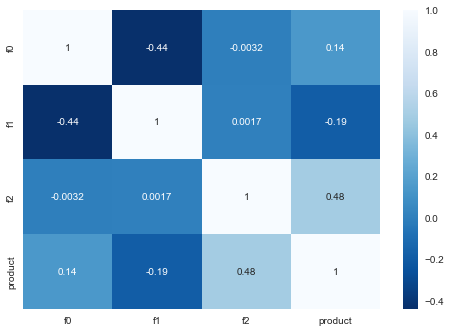

Парные графики признаков:


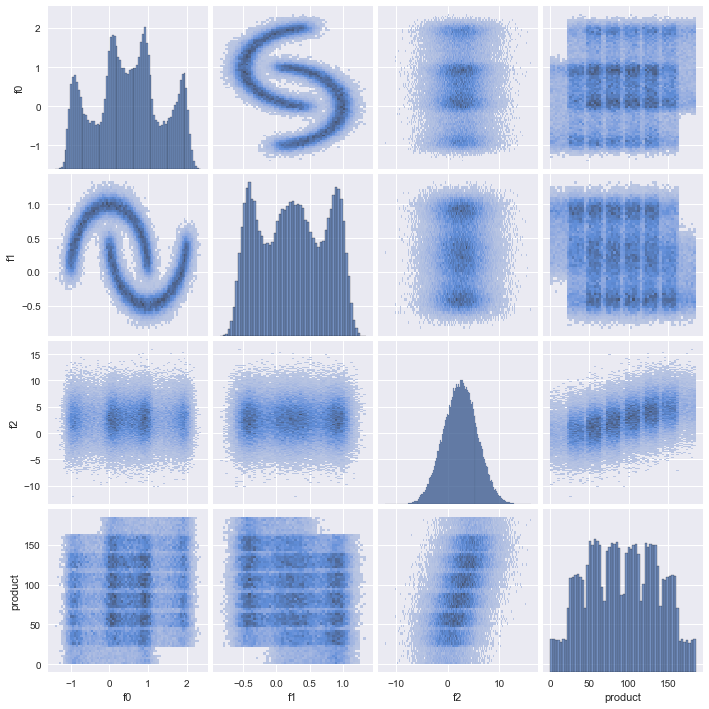

In [6]:
df_describe(well_1)

### Регион 2
------

Описание переменных
               f0          f1          f2     product
count 100,000.000 100,000.000 100,000.000 100,000.000
mean        1.141      -4.797       2.495      68.825
std         8.966       5.120       1.704      45.944
min       -31.610     -26.359      -0.018       0.000
25%        -6.299      -8.268       1.000      26.953
50%         1.153      -4.813       2.011      57.086
75%         8.621      -1.333       4.000     107.813
max        29.422      18.734       5.020     137.945
*******************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   f0       100000 non-null  float64
 1   f1       100000 non-null  float64
 2   f2       100000 non-null  float64
 3   product  100000 non-null  float64
dtypes: float64(4)
memory usage: 3.1 MB
None
*******************************************
Выборка:
         

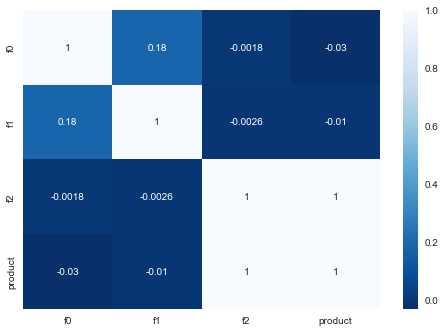

Парные графики признаков:


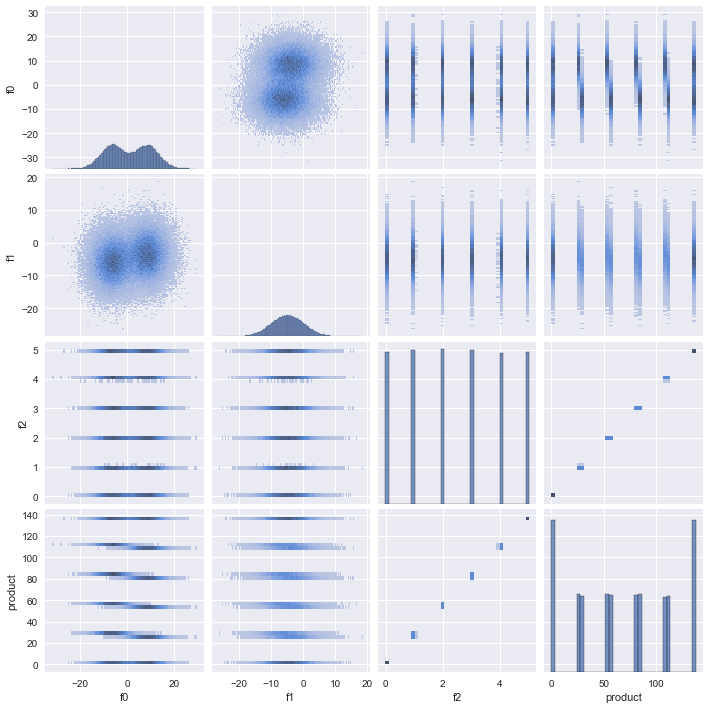

In [7]:
df_describe(well_2)

### Регион 3
------

Описание переменных
               f0          f1          f2     product
count 100,000.000 100,000.000 100,000.000 100,000.000
mean        0.002      -0.002       2.495      95.000
std         1.732       1.730       3.473      44.750
min        -8.760      -7.084     -11.970       0.000
25%        -1.162      -1.175       0.130      59.450
50%         0.009      -0.009       2.484      94.926
75%         1.159       1.164       4.859     130.595
max         7.238       7.845      16.739     190.030
*******************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   f0       100000 non-null  float64
 1   f1       100000 non-null  float64
 2   f2       100000 non-null  float64
 3   product  100000 non-null  float64
dtypes: float64(4)
memory usage: 3.1 MB
None
*******************************************
Выборка:
         

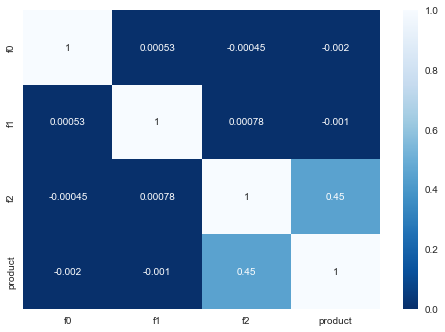

Парные графики признаков:


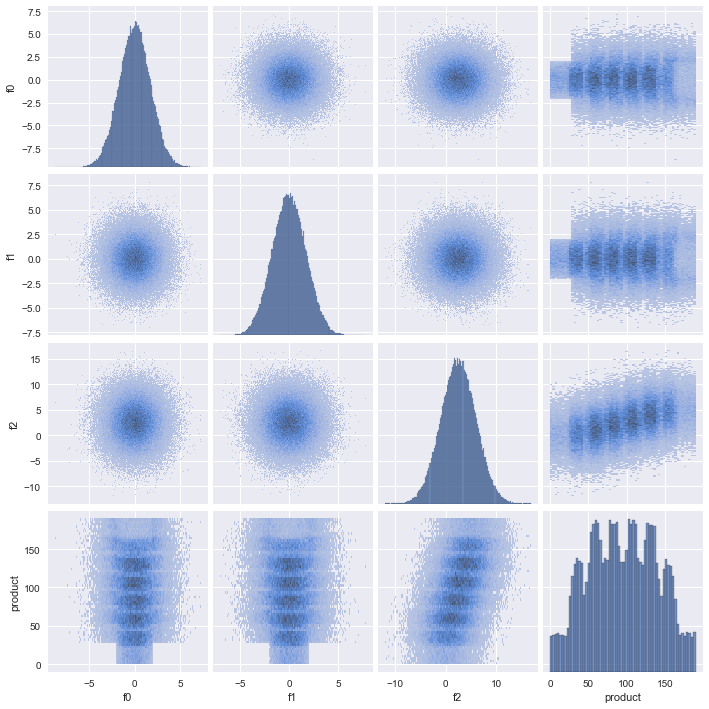

In [8]:
df_describe(well_3)

<div style="border:solid #8B008B 1px; padding: 20px">

Выведем более подробно информацию по скважинам в регионах.

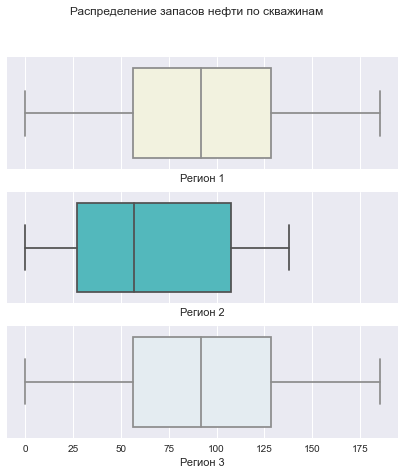

Статистика по запасам нефти в регионах


,Регион 1,Регион 2,Регион 3
count,"100,000.000","100,000.000","100,000.000"
mean,92.500,68.825,95.000
std,44.289,45.944,44.750
min,0.000,0.000,0.000
25%,56.498,26.953,59.450
50%,91.850,57.086,94.926
75%,128.564,107.813,130.595
max,185.364,137.945,190.030


In [9]:

fig, axes = plt.subplots(3, 1, sharex=True, figsize=(7,7))
sns.boxplot(data=well_1, x='product', ax=axes[0], color='beige')
sns.boxplot(data=well_2, x='product', ax=axes[1], color='#42C8CD')
sns.boxplot(data=well_1, x='product', ax=axes[2], color='#E2EDF3')
axes[0].set_xlabel('Регион 1')
axes[1].set_xlabel('Регион 2')
axes[2].set_xlabel('Регион 3')
fig.suptitle('Распределение запасов нефти по скважинам')
plt.show()

product_metrics = pd.DataFrame()
for i, df in enumerate([well_1, well_2, well_3], start=1):
    product_metrics[f'Регион {i}'] = df.describe()['product']

print('Статистика по запасам нефти в регионах')    
display(product_metrics)

### Выводы

<div style="border:solid #9ACD32 2px; padding: 20px">

В датасетах отсутствуют пропуски и дубликаты. В регионах 1 и 3 признаки и целевая переменная имеют схожее распределение. 

Во втором регионе средний запас в скважинах существенно ниже, чем в двух регионах, и распределен кластерно. Также признак f2 в регионе 2 имеет линейную зависимость с целевой переменной, что подтверждается также значением к-та корреляции Пирсона, равном единице.

В ходе предобработки мы только избавились от ненужного столбца id, после чего можно приступить непосредственно к моделированию.

## Обучение и проверка модели

<div style="border:solid #8B008B 1px; padding: 20px">

**Цель обучения** - научить модель предсказывать по набору параметров объем запаса нефти в скважине. Результатом модели должно быть числовое значение, для этого в процессе машинного обучения мы будем использовать модель линейной регрессии. 

Создадим несколько вспомогательных функций.

In [10]:
def split_data(data_for_split):
    '''
    функция разделяет датасет на обучающую и валидационную выборки
    в соотношении 75% / 25%
    '''
    features = data_for_split.drop('product', axis=1)
    target = data_for_split['product']
    
    features_train, features_valid, target_train, target_valid = train_test_split(
        features, target,  test_size=0.25, random_state=SEED)
    # print(f'Размеры выборок:\n features_train - {features_train.shape}, target_train - {target_train.shape}\n features_valid = {features_valid.shape}, target_valid - {target_valid.shape}')
    return features_train, features_valid, target_train, target_valid

def lr_model(df, region_num=None):
    '''
    функция дает прогноз целевой переменной по модели линейной регрессии
    '''
    # разбиваем датасет на выборки
    features_train, features_valid, target_train, target_valid = split_data(df)
    
    # обучаем модель регрессии
    lr = LinearRegression(n_jobs=-1).fit(features_train, target_train)
    
    # прогнозные значения
    pred_valid = lr.predict(features_valid)
    
    results = {'mean_prediction': [], 'mean_target': [], 'rmse': []}
    results['mean_prediction'] = pred_valid.mean()
    results['mean_target'] = target_valid.mean()
    
    # рассчитываем RMSE
    results['rmse'] = mean_squared_error(target_valid, pred_valid)**0.5
    
    # print(f'RMSE модели в Регионе {region_num} = {rmse}')
    
    return pd.DataFrame({'target_reg': target_valid, 'pred_reg': pred_valid}), results


In [11]:
# запишем в переменные и выведем результаты обучения моделей
lr_predictions = []
region_metrics = []
for i, df in enumerate([well_1, well_2, well_3], start=1):
    lr_predictions.append(lr_model(df, i)[0])
    region_metrics.append(lr_model(df, i)[1])
    
print('Метрики моделей по валидационным выборкам')
region_metrics_df = pd.DataFrame(region_metrics, index=range(1, 4))
# region_metrics_df['Среднее по всей выборке'] = product_metrics.iloc[1].values
region_metrics_df

Метрики моделей по валидационным выборкам


,mean_prediction,mean_target,rmse
1,92.599,92.734,37.789
2,69.120,69.127,0.890
3,95.058,95.300,40.009


<div style="border:solid #9ACD32 2px; padding: 20px">

Модель линейной регрессии адекватно описывает имеющиеся данные, метрики предсказаний схожи с метриками исходных данных.

Средние показатели запаса скважин в регионах 1 и 3 схожи и, как уже отмечалось ранее, выше чем в регионе 2. Однако уровень ошибки при прогнозировании находится на очень высоком уровне - 38-40 тыс. баррелей. В тоже время наличие линейных закономерностей в признаках региона 2 дает возможность практически с 1%-й погрешностью дать прогноз запасов скважины в данном регионе.



## Подготовка к расчёту прибыли

<div style="border:solid #8B008B 1px; padding: 20px">

Посчитаем средний бюджет на разработку скважины при заданных параметрах бюджета на регион и количества скважин.

In [12]:
one_well_cost = TOTAL_BUDGET / WELLS_PER_REGION
print(one_well_cost)

50000000.0


<div style="border:solid #8B008B 1px; padding: 20px">

Посчитаем какой запас нефти должен быть в скважине, чтобы ее разработка принесла нулевую прибыль (точка безубыточности).

In [13]:
min_well_reserve = one_well_cost / BARREL_PROFIT
print(min_well_reserve)

111.11111111111111


In [26]:
region_reserves = (region_metrics_df[['mean_prediction']].copy()
                   .assign(
                     reserve_needed = min_well_reserve,
                     deficit = lambda x: x['mean_prediction'] - x['reserve_needed'],
                     deficit_in_percent = lambda x: x['deficit'] / x['reserve_needed'] * 100
                   )
                   )
print('Анализ средних запасов в регионах')
display(region_reserves)

Анализ средних запасов в регионах


,mean_prediction,reserve_needed,deficit,deficit_in_percent
1,92.599,111.111,-18.512,-16.661
2,69.120,111.111,-41.992,-37.792
3,95.058,111.111,-16.053,-14.448


<div style="border:solid #9ACD32 2px; padding: 15px">

Разработка одной скважины обходится в среднем в 50 млн. рублей. Для получения прибыли от разработки скважины необходимо, чтобы запас нефти в этой скважине был не менее 111 тыс. баррелей. Средние запасы скважин во всех регионах существенно ниже требуемой величины. Следовательно, необходимо найти способ точного отбора скважин, удовлетворяющих условиям бизнеса.



## Расчёт прибыли и рисков 

<div style="border:solid #8B008B 1px; padding: 20px">

Функция для расчета прибыли.

In [15]:
def wells_profit(data, count):
    revenue = (
        (data.sort_values('pred_reg', ascending=False)
        .head(count)
        ['target_reg'] * BARREL_PROFIT)
        .sum()
        )
    
    return revenue - one_well_cost * count

<div style="border:solid #8B008B 1px; padding: 20px">

Создадим бутстреп-выборки по каждому региону и рассчитаем ожидаемую прибыль по каждой выборке.

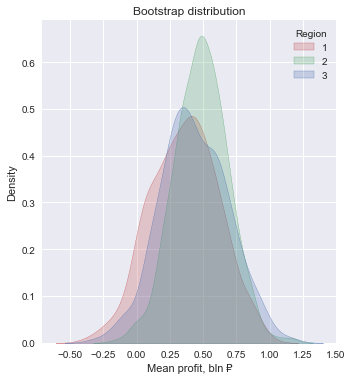

In [17]:
# фиксируем случайное состояние
state = np.random.RandomState(SEED)

bootstrap = {}
for reg, df in enumerate(lr_predictions, 1):
    bootstrap[reg] = []
    for sample in range(BOOTSTRAP_SAMPLES):
        sub = df.sample(WELL_POINTS, replace=True, random_state=state)
        # прибыль по выборке в млрд. рублей
        bootstrap[reg].append(wells_profit(sub, WELLS_PER_REGION)/1e9) 

bootstrap = pd.DataFrame.from_dict(bootstrap)
# отобразим получившиеся распределения средних значений 
g = sns.displot(bootstrap, kind="kde", fill=True, legend=False)
g.set_axis_labels("Mean profit, bln ₽")
plt.legend([1,2,3], title='Region')
plt.title("Bootstrap distribution")
plt.show()

In [22]:
# границы двустороннего доверительного интервала
lower = (1 - CONF_INTERVAL) / 2
upper = (1 + CONF_INTERVAL) / 2

In [27]:
# соберем все результаты бутстрэпа в одну таблицу
results = (bootstrap.describe().iloc[[1,2]].T
          .assign(
              loss_count = lambda x: (bootstrap < 0).sum(),
              loss_percent = lambda x: x['loss_count'] / len(bootstrap) * 100,
              lowerb = lambda x: bootstrap.quantile(lower),
              upperb = lambda x: bootstrap.quantile(upper)
          )
          )
print('Результаты статистической проверки')
display(results)

Результаты статистической проверки


,mean,std,loss_count,loss_percent,lowerb,upperb
1,0.432,0.257,41,4.100,-0.080,0.933
2,0.485,0.202,12,1.200,0.079,0.872
3,0.358,0.256,78,7.800,-0.149,0.861


## Итоги

<div style="border:solid #9ACD32 2px; padding: 20px">

Мы провели обучение модели линейной регрессии для предсказания объема запасов нефти в скважинах разных регионов. На основе данной модели проверили техникой бутстрэпа экономические перспективы разработки скважин в каждом из 3-х предложенных регионов.

Выводы:

1. Первый и третий регионы не проходят по критерию минимальной границы доли убыточных скважин. Критерий задан на уровне 2.5%, а получены результаты - 4.1% и 7.8% соответственно.
2. Второй регион имеет низкую долю потенциально убыточных скважин, отбираемых по нашей модели, - 1.2%. Кроме того в этом регион максимальная средняя прибыль и наименьшее стандартное отклонение, значения прибыли с 95% вероятностью лежат в диапазоне от 79 до 872 млн. рублей.

*Оптимальный выбор в данной задаче - **регион 2.***



## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнен шаг 1: данные подготовлены
- [x]  Выполнен шаг 2: модели обучены и проверены
    - [x]  Данные корректно разбиты на обучающую и валидационную выборки
    - [x]  Модели обучены, предсказания сделаны
    - [x]  Предсказания и правильные ответы на валидационной выборке сохранены
    - [x]  На экране напечатаны результаты
    - [x]  Сделаны выводы
- [ ]  Выполнен шаг 3: проведена подготовка к расчёту прибыли
    - [x]  Для всех ключевых значений созданы константы Python
    - [x]  Посчитано минимальное среднее количество продукта в месторождениях региона, достаточное для разработки
    - [x]  По предыдущему пункту сделаны выводы
    - [x]  Написана функция расчёта прибыли
- [ ]  Выполнен шаг 4: посчитаны риски и прибыль
    - [x]  Проведена процедура *Bootstrap*
    - [x]  Все параметры бутстрепа соответствуют условию
    - [x]  Найдены все нужные величины
    - [x]  Предложен регион для разработки месторождения
    - [x]  Выбор региона обоснован